In [1]:
# import libraries

import ROOT
import numpy as np
from collections import defaultdict
import pandas as pd
from IPython.display import Image
from subprocess import call

import hax
hax.init(main_data_paths=['/project/lgrandi/tunnell/run_14/Kr83mDiffusion_Pax4.9.1/',
                          '/project/lgrandi/xenon100/archive/root/merged/xenon100/run_14_pax4.1.2/'],
         raw_data_local_path='/project/lgrandi/tunnell/')

from Kr83m_Basic import *

def atan(y, x):
    phi = np.arctan2(y, x)
    for i in range(len(phi)):
        if phi[i] < 0: 
            phi[i] += 2*np.pi
    return phi

#hax.ipython.code_hider()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
# datasets processed by pax_4.1.2
datasets = ['xe100_150413_1839','xe100_150414_1535',
               'xe100_150419_1611','xe100_150420_0304',
               'xe100_150420_1809']

In [3]:
# load minitrees
# throws error when building minitrees for many datasets, I built them one by one

data = hax.minitrees.load(datasets, treemakers=Kr83m_Basic)
data = data[data['s10Time']>=0]
print(len(data))

Found minitree at ./xe100_150413_1839_Kr83m_Basic.root
Found minitree at ./xe100_150414_1535_Kr83m_Basic.root
Found minitree at ./xe100_150419_1611_Kr83m_Basic.root
Found minitree at ./xe100_150420_0304_Kr83m_Basic.root
Found minitree at ./xe100_150420_1809_Kr83m_Basic.root
858712


In [4]:
# df = data[ (data['s10Coin']>=2) & (data['s11Coin']>=2) & 
#            (data['cs20Area']>=150) & (data['s21Area']<=150) &
#            (data['s11Time']-data['s10Time']>=500) & (data['s11Time']-data['s10Time']<=1000) &
#            (data['s11Area']/data['s10Area']>0.1) & (data['s11Area']/data['s10Area']<1.0) ]
df = data[ (data['s10Coin']>=3) & (data['s20Coin']>=4) & (data['s11Coin']>=2) & 
           ((data['s21Area']==0) | (data['s21Area']>=200)) & (data['s11Area']>7) &
           (data['s11Time']-data['s10Time']>0)]

In [ ]:
pi = np.pi
R = 15.25
Z = 30.3
N_z = 10.0
z_0 = Z/N_z
N_phi = [10, 15, 20, 40, 60]
phi_0 = [2*pi/10, 2*pi/15, 2*pi/20, 2*pi/40, 2*pi/60]
A_r = [R/5, 2*R/5, 3*R/5, 4*R/5, R]

bin_data = defaultdict(list)


for z_i in range(int(N_z)):
    
    z_min = z_i * z_0
    z_max = (z_i+1) * z_0
    df_z = df[ (df['s11z']>z_min) & (df['s11z']<=z_max) ]
    
    for r_i in range(len(A_r)):
        
        if r_i == 0:
            r_min = 0
        else:
            r_min = A_r[r_i-1]
        r_max = A_r[r_i]
        df_r = df_z[ ( np.sqrt(df_z['s11x']**2 + df_z['s11y']**2)>r_min )
                   & ( np.sqrt(df_z['s11x']**2 + df_z['s11y']**2)<=r_max )]
        
        for phi_i in range(N_phi[r_i]):
            
            bin_data['z_i'].append(z_i)
            bin_data['z'].append( (z_max + z_min)/2 )
            bin_data['r_i'].append(r_i)
            bin_data['r'].append( (r_max + r_min)/2 )
            bin_data['phi_i'].append(phi_i)
            phi_min = phi_i * phi_0[r_i] 
            phi_max = (phi_i+1) * phi_0[r_i] 
            bin_data['phi'].append( (phi_max + phi_min)/2 )
            
            df_phi = df_r[ (atan(df_r['s11y'].values, df_r['s11x'].values) > phi_min) 
                         & (atan(df_r['s11y'].values, df_r['s11x'].values) <= phi_max )]
            
            bin_data['N'].append(len(df_phi))
            
            c1 = ROOT.TCanvas('','', 800, 700)
            hist = ROOT.TH1D('','', 100, 0, 100)
            for i in range(len(df_phi['s11Area'])):
                hist.Fill(df_phi['s11Area'].values[i])
            hist.SetTitle('9 keV Spectrum: \
                          %.1f < z < %.1f, %.1f < r < %.1f, %.1f < phi < %.1f,'
                          %(z_min, z_max, r_min, r_max, phi_min, phi_max))
            hist.GetXaxis().SetTitle('s11Area (pe)')
            hist.GetXaxis().CenterTitle()
            hist.Sumw2()
            hist.SetStats(False)
            hist.Draw()
            hist.Fit('gaus')
            fit = hist.GetFunction('gaus')
            chi2 = fit.GetChisquare()
            ndf = fit.GetNDF()
            p0 = fit.GetParameter(0)
            e0 = fit.GetParError(0)
            p1 = fit.GetParameter(1)
            e1 = fit.GetParError(1)
            p2 = fit.GetParameter(2)
            e2 = fit.GetParError(2)
            
            pt = ROOT.TPaveText(.58, .68, .88, .88, 'NDC')
            pt.AddText('Entries = %d'%len(df_phi))
            pt.AddText('#mu = %1.3f #pm %1.3f'%(p1, e1))
            pt.AddText('#sigma = %1.3f #pm %1.3f' %(p2, e2))
            pt.AddText('Amplitude = %1.3f #pm %1.3f' %(p0, e0))
            pt.AddText('#chi^{2}/NDF = %1.3f/%1.3f' %(chi2, ndf))
            
            pt.Draw()
            
            c1.Print('Bin_Hists/f_z%d_r%d_phi%d.png' %(z_i, r_i, phi_i))
            c1.Clear()
            hist.Delete()
            
            bin_data['<s11Area>'].append(p1)
            bin_data['error'].append(e1)

In [5]:
pi = np.pi
R = 15.25
Z = 30.3
N_z = 10.0
z_0 = Z/N_z
N_phi = [10, 15, 20, 40, 60]
phi_0 = [2*pi/10, 2*pi/15, 2*pi/20, 2*pi/40, 2*pi/60]
A_r = [R/5, 2*R/5, 3*R/5, 4*R/5, R]

bin_data = defaultdict(list)


for z_i in range(int(N_z)):
    
    z_min = z_i * z_0
    z_max = (z_i+1) * z_0
    df_z = df[ (df['s10z']>z_min) & (df['s10z']<=z_max) ]
    
    for r_i in range(len(A_r)):
        
        if r_i == 0:
            r_min = 0
        else:
            r_min = A_r[r_i-1]
        r_max = A_r[r_i]
        df_r = df_z[ ( np.sqrt(df_z['s10x']**2 + df_z['s10y']**2)>r_min )
                   & ( np.sqrt(df_z['s10x']**2 + df_z['s10y']**2)<=r_max )]
        
        for phi_i in range(N_phi[r_i]):
            
            bin_data['z_i'].append(z_i)
            bin_data['z'].append( (z_max + z_min)/2 )
            bin_data['r_i'].append(r_i)
            bin_data['r'].append( (r_max + r_min)/2 )
            bin_data['phi_i'].append(phi_i)
            phi_min = phi_i * phi_0[r_i] 
            phi_max = (phi_i+1) * phi_0[r_i] 
            bin_data['phi'].append( (phi_max + phi_min)/2 )
            
            df_phi = df_r[ (atan(df_r['s10y'].values, df_r['s10x'].values) > phi_min) 
                         & (atan(df_r['s10y'].values, df_r['s10x'].values) <= phi_max )]
            
            bin_data['N'].append(len(df_phi))
            
            c1 = ROOT.TCanvas('','', 800, 700)
            hist = ROOT.TH1D('','', 100, 0, 200)
            for i in range(len(df_phi['s10Area'])):
                hist.Fill(df_phi['s10Area'].values[i])
            hist.SetTitle('32 keV Spectrum: \
                          %.1f < z < %.1f, %.1f < r < %.1f, %.1f < phi < %.1f,'%(z_min, z_max, r_min, r_max, phi_min, phi_max))
            hist.GetXaxis().SetTitle('s10Area (pe)')
            hist.GetXaxis().CenterTitle()
            hist.Sumw2()
            hist.SetStats(False)
            hist.Draw()
            hist.Fit('gaus')
            fit = hist.GetFunction('gaus')
            chi2 = fit.GetChisquare()
            ndf = fit.GetNDF()
            p0 = fit.GetParameter(0)
            e0 = fit.GetParError(0)
            p1 = fit.GetParameter(1)
            e1 = fit.GetParError(1)
            p2 = fit.GetParameter(2)
            e2 = fit.GetParError(2)
            
            pt = ROOT.TPaveText(.58, .68, .88, .88, 'NDC')
            pt.AddText('Entries = %d'%len(df_phi))
            pt.AddText('#mu = %1.3f #pm %1.3f'%(p1, e1))
            pt.AddText('#sigma = %1.3f #pm %1.3f' %(p2, e2))
            pt.AddText('Amplitude = %1.3f #pm %1.3f' %(p0, e0))
            pt.AddText('#chi^{2}/NDF = %1.3f/%1.3f' %(chi2, ndf))
            
            pt.Draw()
            
            c1.Print('Bin_Hists/f_z%d_r%d_phi%d.png' %(z_i, r_i, phi_i))
            c1.Clear()
            hist.Delete()
            
            bin_data['<s10Area>'].append(p1)
            bin_data['error'].append(e1)

In [ ]:
df2 = pd.DataFrame(bin_data)

#declare and fill hist for each z_i

dummyH_list=[]

c1 = ROOT.TCanvas( '','', 2400, 3200 ) 
c1.Divide(3,4,0.02,0.02)

z_hists = []

for z_i in range(int(N_z)):
    
    dummyH_list.append(ROOT.TH2D("","",100,-R,R,100,-R,R))
    
    df2_new = df2[ df2['z_i'] == z_i ]
    hists = []
    for r_i in range(len(A_r)):
        hists.append(ROOT.TH2D('','', N_phi[r_i], 0, 2*np.pi, len(A_r), 0, R ))
        df2_newer = df2_new[ df2_new['r_i'] == r_i ]
        for i in range(len(df2_newer)):
            hists[r_i].Fill(df2_newer['phi'].values[i], df2_newer['r'].values[i],
                            df2_newer['<s11Area>'].values[i]/32.1 )
            
    z_hists.append(hists)
                  
    c1.cd(z_i+1)
    
    dummyH_list[z_i].Draw('colz')
    dummyH_list[z_i].SetTitle("%.2fcm < z < %.2fcm" %(z_i*3.03, (z_i+1)*3.03 ))
    dummyH_list[z_i].GetZaxis().SetTitle("<s11Area>")
    dummyH_list[z_i].GetXaxis().SetTitle("x position (cm)")
    dummyH_list[z_i].GetXaxis().CenterTitle()
    dummyH_list[z_i].GetYaxis().SetTitle("y position (cm)")
    dummyH_list[z_i].GetYaxis().CenterTitle()
    
#     c1.SetTopMargin(0.2)
    c1.SetRightMargin(0.2)
    
    for i in range(len(z_hists[z_i])):
        z_hists[z_i][i].GetZaxis().SetRangeUser(0.2, 2)
        z_hists[z_i][i].GetZaxis().SetTitle("<s11Area>")
        z_hists[z_i][i].GetZaxis().SetTitleOffset(1.8)
        z_hists[z_i][i].Draw('pol colz a same') 
            
c1.Print('f_full_LY_s11.png')
c1.Clear()
    
 
Image(filename='f_full_LY_s11.png')

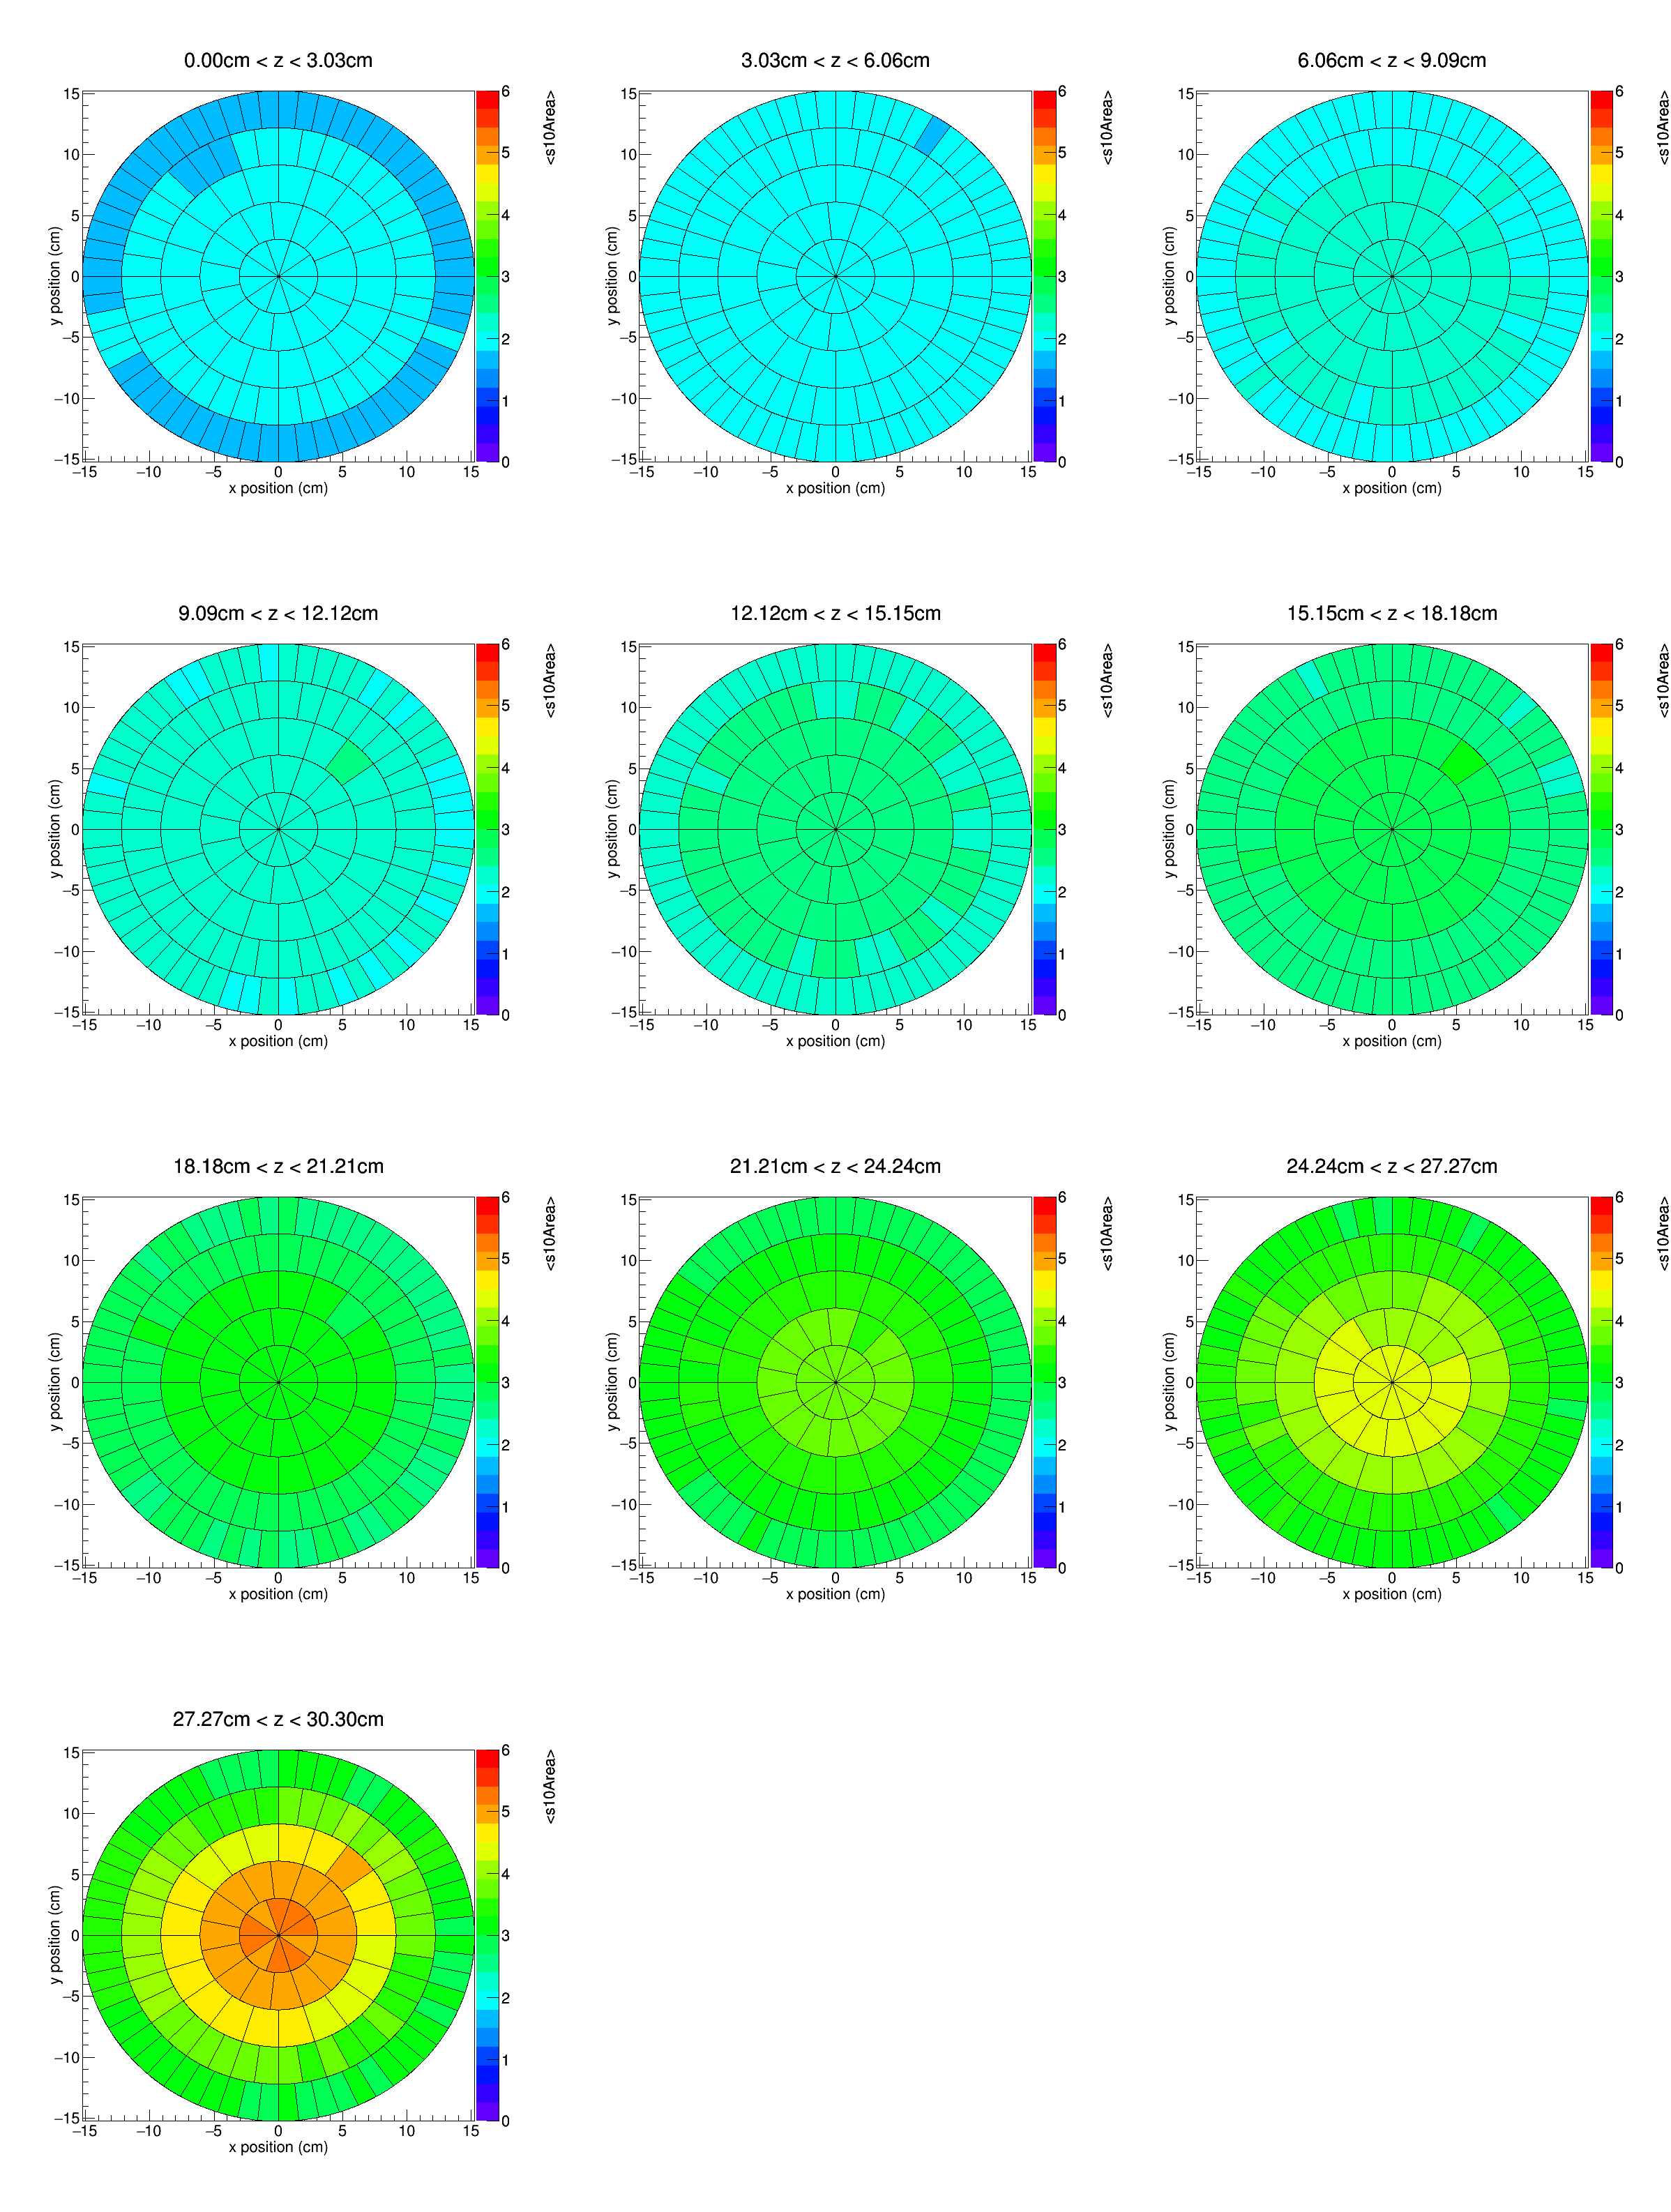

In [9]:
df2 = pd.DataFrame(bin_data)

#declare and fill hist for each z_i

dummyH_list=[]

c1 = ROOT.TCanvas( '','', 2400, 3200 ) 
ROOT.gStyle.SetOptStat(0)
c1.Divide(3,4,0.02,0.02)

z_hists = []

for z_i in range(int(N_z)):
    
    dummyH_list.append(ROOT.TH2D("","",100,-R,R,100,-R,R))
    
    df2_new = df2[ df2['z_i'] == z_i ]
    hists = []
    for r_i in range(len(A_r)):
        hists.append(ROOT.TH2D('','', N_phi[r_i], 0, 2*np.pi, len(A_r), 0, R ))
        df2_newer = df2_new[ df2_new['r_i'] == r_i ]
        for i in range(len(df2_newer)):
            hists[r_i].Fill(df2_newer['phi'].values[i], df2_newer['r'].values[i],
                            df2_newer['<s10Area>'].values[i]/32.1 )
            
    z_hists.append(hists)
                  
    c1.cd(z_i+1)
    
    dummyH_list[z_i].Draw('colz')
    dummyH_list[z_i].SetTitle("%.2fcm < z < %.2fcm" %(z_i*3.03, (z_i+1)*3.03 ))
    dummyH_list[z_i].GetZaxis().SetTitle("<s10Area>")
    dummyH_list[z_i].GetXaxis().SetTitle("x position (cm)")
    dummyH_list[z_i].GetXaxis().CenterTitle()
    dummyH_list[z_i].GetYaxis().SetTitle("y position (cm)")
    dummyH_list[z_i].GetYaxis().CenterTitle()
    
#     c1.SetTopMargin(0.2)
    c1.SetRightMargin(0.2)
    
    for i in range(len(z_hists[z_i])):
        z_hists[z_i][i].GetZaxis().SetRangeUser(0, 6)
        z_hists[z_i][i].GetZaxis().SetTitle("<s10Area>")
        z_hists[z_i][i].GetZaxis().SetTitleOffset(1.8)
        z_hists[z_i][i].Draw('pol colz a same') 
            
c1.Print('f_full_LY_s10.png')
c1.Clear()
    
 
Image(filename='f_full_LY_s10.png')

In [ ]:
#declare and fill hist for each z_i

dummyH_list=[]

c1 = ROOT.TCanvas( '','', 2400, 3200 ) 
c1.Divide(3,4,0.02,0.02)

z_hists = []

for z_i in range(int(N_z)):
    dummyH_list.append(ROOT.TH2D("","",100,-R,R,100,-R,R))
    
    df2_new = df2[ df2['z_i'] == z_i ]
    hists = []
    for r_i in range(len(A_r)):
        hists.append(ROOT.TH2D('','', N_phi[r_i], 0, 2*np.pi, len(A_r), 0, R ))
        df2_newer = df2_new[ df2_new['r_i'] == r_i ]
        for i in range(len(df2_newer)):
            hists[r_i].Fill(df2_newer['phi'].values[i], df2_newer['r'].values[i],
                            df2_newer['N'].values[i] )
            
    z_hists.append(hists)
                  
    c1.cd(z_i+1)
    
    dummyH_list[z_i].Draw('colz')
    dummyH_list[z_i].SetTitle("%.2fcm < z < %.2fcm" %(z_i*3.03, (z_i+1)*3.03 ))
    dummyH_list[z_i].GetZaxis().SetTitle("Nu")
    dummyH_list[z_i].GetXaxis().SetTitle("x position (cm)")
    dummyH_list[z_i].GetXaxis().CenterTitle()
    dummyH_list[z_i].GetYaxis().SetTitle("y position (cm)")
    dummyH_list[z_i].GetYaxis().CenterTitle()
    
#     c1.SetTopMargin(0.2)
    c1.SetRightMargin(0.2)
    
    for i in range(len(z_hists[z_i])):
        z_hists[z_i][i].GetZaxis().SetRangeUser(0, 1000)
        z_hists[z_i][i].GetZaxis().SetTitle("Number of events")
        z_hists[z_i][i].GetZaxis().SetTitleOffset(1.8)
        z_hists[z_i][i].Draw('pol colz a same') 

c1.SetTitle("Average S10 Area per Bin")
            
c1.Print('f_full_LY_N.png')
c1.Clear()
    
 
Image(filename='f_full_LY_N.png')